In [ ]:
#Install required packages
%pip install -U langgraph langchain_community langchain_openai langsmith langgraph-supervisor 

In [1]:
# Environment Variable Initialization

import getpass
import os

def _set_if_undefined(var_name: str):
    """
    Set an environment variable if it is not already defined.
    
    Args:
        var_name (str): Name of the environment variable to set.
    """
    if not os.environ.get(var_name):
        # Securely prompt the user for input without echoing it on screen
        os.environ[var_name] = getpass.getpass(f"Please provide your {var_name}: ")

# ---- Environment Variables Required ----

_set_if_undefined("OPENAI_API_KEY")         # API key for OpenAI models
_set_if_undefined("ANTHROPIC_API_KEY")      # API key for OpenAI models
_set_if_undefined("LANGSMITH_TRACING")      # Enable LangSmith tracing ("true" to enable)
_set_if_undefined("LANGSMITH_API_KEY")      # API key for LangSmith platform
_set_if_undefined("OPENAI_MODEL")           # Model name (e.g., "gpt-4.1" "gpt-4o", "gpt-3.5-turbo")
_set_if_undefined("ANTHROPIC_MODEL")        # Model name (e.g., "claude-3-7-sonnet-latest")

In [ ]:
# Multi-Agent Orchestration with LangGraph:
#- Supervisor agent coordinates between specialized workers.
#- Workers: weather reporting agent, dressing planner agent, image generator.
# ---- Imports ----
import os
from langchain_openai import ChatOpenAI
from typing import Annotated
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool

# ---- LLM Setup ----

# Load the default model from environment variables
default_model = os.environ["OPENAI_MODEL"]

# Initialize the LLM (Large Language Model) interface
llm = ChatOpenAI(model=default_model)

# ---- Node Definitions ----

# Dressing Planner Agent
adults_dressing_planner_agent = create_react_agent(
    llm,
    tools=[],
    name="adults_dressing_planner_agent",
    prompt=(
        "You suggest dressing options for adults based on the current weather and UV index. "
        "Prioritize UV index, 'feels like' temperature and consider wind conditions."
    )
)

# Dressing Planner Agent
childrens_dressing_planner_agent = create_react_agent(
    llm,
    tools=[],
    name="childrens_dressing_planner_agent",
    prompt=(
        "You suggest dressing options for children based on the current weather and UV index. "
        "Prioritize UV index, 'feels like' temperature and consider wind conditions."
    )
)

# ---- Supervisor Setup ----


# System prompt guiding the supervisor's behavior
dressing_system_prompt = (
    "# Role and Objective"
    "You are a Supervisor Agent tasked with managing a conversation between multiple specialized workers: "
    "`adults_dressing_planner_agent`, and `childrens_dressing_planner_agent`."
    "Your goal is to suggest dressing options based on the weather, UV index and persons age"
    "orchestrate worker actions to resolve the user's request efficiently."
    "# Instructions"
    " - Persist through multiple steps until the task is fully complete."
    " - Always select the next worker based on context."
    " - Think step-by-step before choosing a worker and after receiving results."
    "# Reasoning Steps"
    "1. Analyze current state."
    "2. Plan the next best action."
    "3. Reflect after worker output."
    "4. Repeat until completion."
    "# Tool/Worker Use"
    "- `adults_dressing_planner_agent`: suggest clothing for adults based on the weather and UV index"
    "- `childrens_dressing_planner_agent`: suggest clothing for children based on the weather and UV index"
)

# Create supervisor
dressing_supervisor = create_supervisor(
    agents=[adults_dressing_planner_agent, childrens_dressing_planner_agent],
    model=llm,
    prompt=(dressing_system_prompt),
    supervisor_name="dressing_supervisor"
)

dressing_team = dressing_supervisor.compile(name="dressing_team")


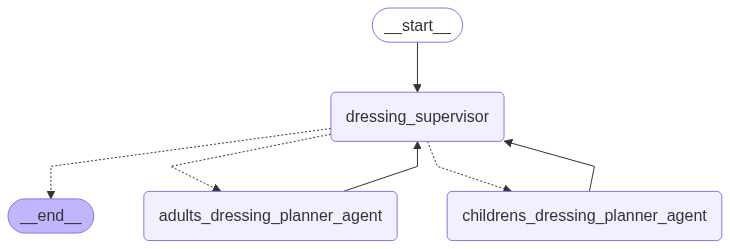

In [7]:
from IPython.display import display, Image
display(Image(dressing_team.get_graph().draw_mermaid_png()))

In [ ]:

for s in dressing_team.stream(
    {"messages": [("user", "The Stockholm weather forecast for today indicates mostly light rain showers with a gentle breeze. UV index is 3, and we are family of 3, a 5 year old child, a 40 year old father and a 90 year old grand mother")]}, debug=True):
    print(s)
    print("============================")

[-1:checkpoint] State at the end of step -1:
{'messages': []}
[0:tasks] Starting 1 task for step 0:
- __start__ -> {'messages': [('user',
               'The Stockholm weather forecast for today indicates mostly '
               'light rain showers with a gentle breeze. UV index is 3, and we '
               'are family of 3, one 5 year old child, one 40 year old adult '
               'and a small dog')]}
[0:writes] Finished step 0 with writes to 1 channel:
- messages -> [('user',
  'The Stockholm weather forecast for today indicates mostly light rain '
  'showers with a gentle breeze. UV index is 3, and we are family of 3, one 5 '
  'year old child, one 40 year old adult and a small dog')]
[0:checkpoint] State at the end of step 0:
{'messages': [HumanMessage(content='The Stockholm weather forecast for today indicates mostly light rain showers with a gentle breeze. UV index is 3, and we are family of 3, one 5 year old child, one 40 year old adult and a small dog', additional_kwargs={}